In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Load your labeled dataset
df = pd.read_csv("labeled_dataset_4_categories.csv")
df = df[df["Semantic_Label_4"].isin(["support_ban", "oppose_ban", "neutral", "unrelated"])].copy()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jeetshah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jeetshah/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/jeetshah/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
def clean_and_tokenize(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation/numbers
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return tokens

df["tokens"] = df["Text"].apply(clean_and_tokenize)
transactions = df["tokens"].tolist()

In [3]:
from collections import Counter

# Flatten and count
all_words = [word for doc in transactions for word in doc]
common_words = [word for word, freq in Counter(all_words).most_common(100)]

# Filter transactions
filtered_transactions = [[word for word in doc if word in common_words] for doc in transactions]
filtered_transactions = [doc for doc in filtered_transactions if len(doc) > 1]


In [4]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_array = te.fit(filtered_transactions).transform(filtered_transactions)
df_te = pd.DataFrame(te_array, columns=te.columns_)

df_te.head()

,according,across,action,also,animal,area,around,bag,bottle,carbon,...,using,waste,water,way,week,well,work,world,would,year
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,True,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [5]:
from mlxtend.frequent_patterns import apriori, association_rules

frequent_itemsets = apriori(df_te, min_support=0.05, use_colnames=True, max_len=3)

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
rules = rules.sort_values(by="lift", ascending=False)

# View top 15 by lift
rules_top_lift = rules.nlargest(15, 'lift')
rules_top_lift[["antecedents", "consequents", "support", "confidence", "lift"]]


,antecedents,consequents,support,confidence,lift
329478,"(fuel, global)",(fossil),0.104284,0.802273,4.731173
329479,(fossil),"(fuel, global)",0.104284,0.614983,4.731173
150195,(fossil),"(fuel, climate)",0.136484,0.804878,4.641418
150194,"(fuel, climate)",(fossil),0.136484,0.787053,4.641418
329588,(fossil),"(oil, fuel)",0.076219,0.449477,4.624562
329585,"(oil, fuel)",(fossil),0.076219,0.784195,4.624562
492213,(packaging),"(recycling, product)",0.051699,0.356415,4.622477
492212,"(recycling, product)",(packaging),0.051699,0.670498,4.622477
329532,"(fuel, level)",(fossil),0.062334,0.781481,4.608562
329533,(fossil),"(fuel, level)",0.062334,0.367596,4.608562


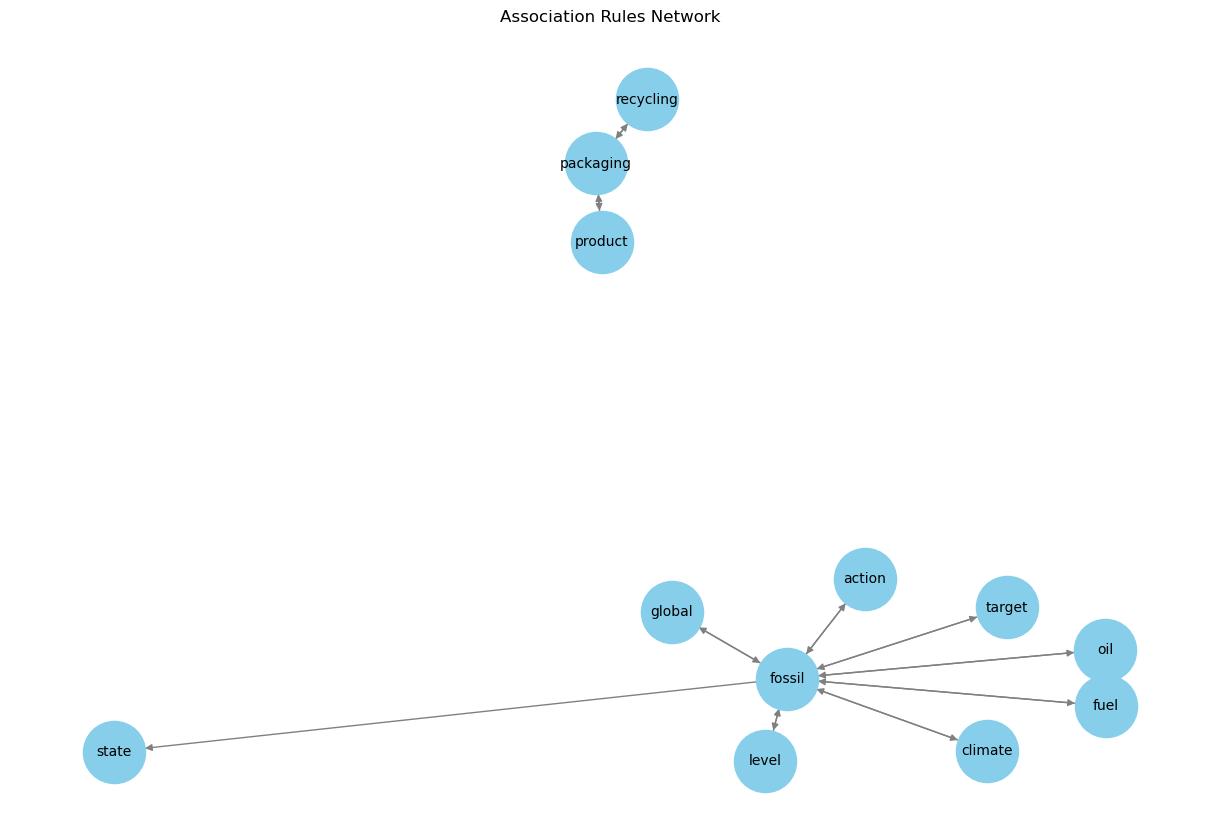

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

top_rules = rules_top_lift

G = nx.DiGraph()

for idx, row in top_rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(antecedent, consequent, weight=row['lift'])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=10, edge_color='gray')
plt.title("Association Rules Network")
plt.show()

/var/folders/j7/q41jdqbs44549h57hb3nhfv00000gn/T/ipykernel_43940/1248451450.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(values), y=list(labels), palette='viridis')


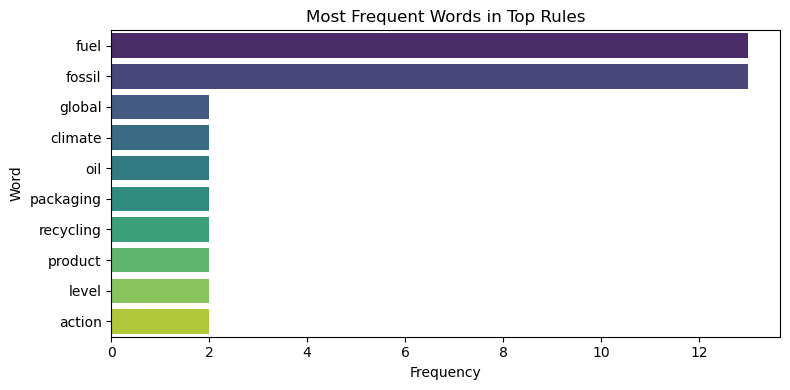

In [8]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

# Flatten all antecedents + consequents
all_items = [item for rule in top_rules["antecedents"].tolist() + top_rules["consequents"].tolist() for item in rule]
word_counts = Counter(all_items).most_common(10)

# Plot
labels, values = zip(*word_counts)
plt.figure(figsize=(8, 4))
sns.barplot(x=list(values), y=list(labels), palette='viridis')
plt.title("Most Frequent Words in Top Rules")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.tight_layout()
plt.show()